In [1]:
# Download the dataset
!wget --no-check-certificate \
    -O /tmp/sentiment.csv  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P


--2025-02-10 20:31:09--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 108.177.12.102, 108.177.12.113, 108.177.12.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2025-02-10 20:31:09--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.001s  

2025-02-10 20:31:11 (90.1 MB

In [3]:
import pandas as pd
dataset = pd.read_csv('/tmp/sentiment.csv')

# Just extract or sentences and labels fisrt- create subword here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

### Create the subword  dataset

In [5]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    sentences, target_vocab_size=vocab_size, max_subword_length=5
)

In [6]:
# Check that the tokenizer works properly
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

# Seperately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))


I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


### Replace sentence data with encoded subwords

In [8]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [9]:
# check the sentences are appropriately replaced
print(sentences[num])


[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


## Final Preprocessing

In [11]:
import numpy as np
from tensorflow.keras.utils import pad_sequences

max_length = 50
trunc_type = 'post'
padding_type = 'post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

# Seperate out the sentences and the labels into training and test sets
training_size = int(len(sentences_padded) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

# Make labels intonumpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)



### Train a sentiment mmodel


In [14]:
embedding_dim = 16
import tensorflow as tf
# Create a Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the Model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fit the Model
num_epochs = 30
history = model.fit(training_sentences, training_labels_final,
                    epochs=num_epochs,
                    validation_data = (testing_sentences,testing_labels_final))

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5364 - loss: 0.6918 - val_accuracy: 0.4286 - val_loss: 0.7035
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5344 - loss: 0.6883 - val_accuracy: 0.4561 - val_loss: 0.7036
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5634 - loss: 0.6819 - val_accuracy: 0.5238 - val_loss: 0.6892
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5898 - loss: 0.6740 - val_accuracy: 0.5714 - val_loss: 0.6768
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6782 - loss: 0.6594 - val_accuracy: 0.7519 - val_loss: 0.6566
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6280 - loss: 0.6500 - val_accuracy: 0.5714 - val_loss: 0.6624
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7137 - loss: 0.6180 - val_accuracy: 0.5388 - val_loss: 0.6692
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7160 - loss: 0.5866 - val_accuracy: 0.7769 - val_loss:

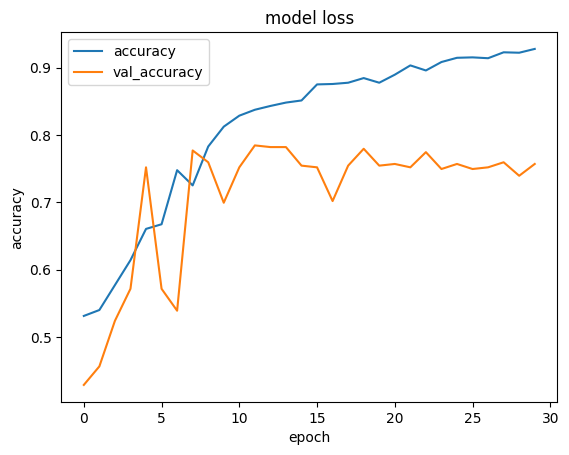

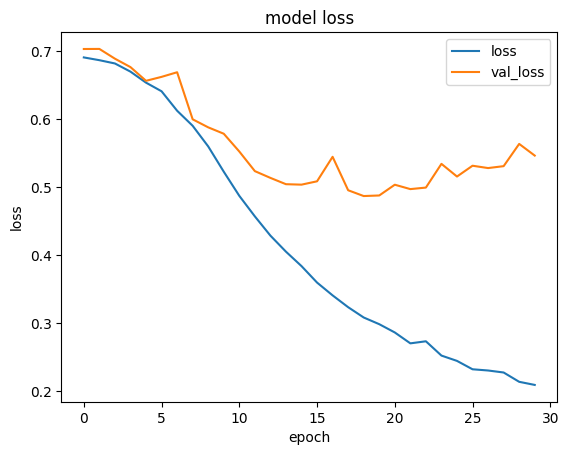

In [16]:
# Visualize the training graph
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('model loss')
    plt.ylabel(string)
    plt.xlabel('epoch')
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')